# Clasificación de drogas utilizando Random Forest y Gaussian Naive Bayes.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score ##puntaje F1
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

Las columnas de la base de datos contienen la siguiente información:


1.   Age: Edad de la persona.
2.   Sex: Género de la persona.
3.   Blood Pressure Levels(BP): Niveles de presión en la sangre la persona.
4.   Cholesterol levels: Niveles de colesterol en la sangre de la persona.
5.   Na to Potassium Ration: Relación de sodio a potasio en la sangre de la persona.
6.   Drug type: Tipo de droga.

El objetivo es construir un modelo de clasificación para la columna Drug type.



In [57]:
#Para correr en colab.
df = pd.read_csv('/drug200.csv')

In [ ]:
# Cargamos los datos, la base de datos debe estar en un directorio llamado data.
df = pd.read_csv('data/drug200.csv')

In [58]:
# Un primer vistazo a la base de datos
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [59]:
#tipos de datos y si existen datos nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [60]:
#Tenemos 200 entradas y 6 columnas
df.shape

(200, 6)

In [7]:
#valores unicos de algunas columnas
print(df['Sex'].unique())
print(df['BP'].unique())
print(df['Cholesterol'].unique())
print(df['Drug'].unique())

['F' 'M']
['HIGH' 'LOW' 'NORMAL']
['HIGH' 'NORMAL']
['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


# Data Cleaning

In [8]:
#No hay valores nulos.
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

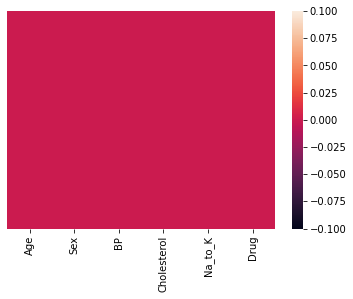

In [9]:
sns.heatmap(df.isnull(),yticklabels=False)

In [10]:
#No hay entradas duplicadas
duplicateRows = df[df.duplicated()]
duplicateRows 

,Age,Sex,BP,Cholesterol,Na_to_K,Drug


In [70]:
# Vamos a codificar algunas variables categoricas como el genero y nuestra variable a predecir Drug.
gender_encoder = LabelEncoder()
drug_encoder = LabelEncoder()


gender_encoder.fit(df['Sex'])
drug_encoder.fit(df['Drug'])


df['Sex'] = gender_encoder.transform(df['Sex'])
df['DrugEncoded'] = drug_encoder.transform(df['Drug'])

In [69]:
#Aqui hacemos una codificación con variables ordinales.

df.loc[df['BP']=='LOW',"BP"] = 0
df.loc[df['BP']=='NORMAL',"BP"] = 1
df.loc[df['BP']=='HIGH',"BP"] = 2

df.loc[df['Cholesterol']=='NORMAL',"Cholesterol"] = 0
df.loc[df['Cholesterol']=='HIGH',"Cholesterol"] = 1

# EDA (Exploratory Data Analysis)

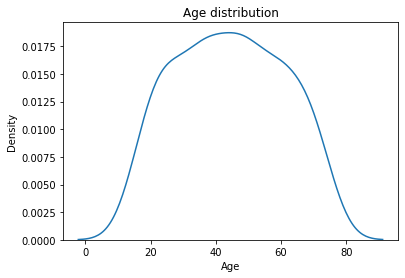

In [46]:
sns.kdeplot(data=df,x='Age')
plt.title('Distribución de la edad')
plt.show()

Text(0.5, 1.0, 'Distribución del genero')

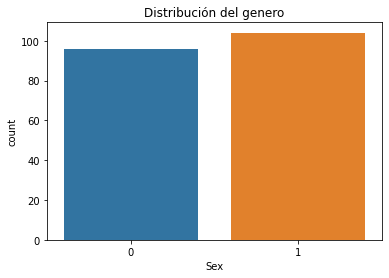

In [48]:
sns.countplot(data=df,x='Sex')
plt.title("Distribución del genero")
plt.show()

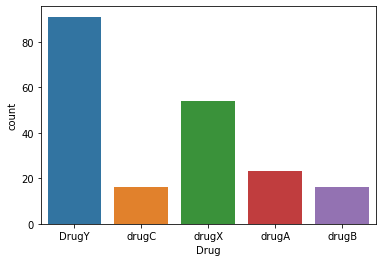

In [14]:
#podemos ver que existe un desbalance de clases.
sns.countplot(data=df,x='Drug')
plt.title('Distribución de los tipos de drogas')
plt.show()

In [15]:
# Estadisticas básicas.
df.describe()

,Age,Sex,Na_to_K,DrugEncoded
count,2.000000e+02,200.000000,2.000000e+02,200.000000
mean,1.373901e-16,0.520000,1.397771e-15,1.595000
std,1.000000e+00,0.500854,1.000000e+00,1.716305
min,-1.771908e+00,0.000000,-1.358741e+00,0.000000
25%,-8.048082e-01,0.000000,-7.805952e-01,0.000000
50%,4.140395e-02,1.000000,-2.973419e-01,1.000000
75%,8.271724e-01,1.000000,4.561926e-01,4.000000
max,1.794272e+00,1.000000,3.067920e+00,4.000000


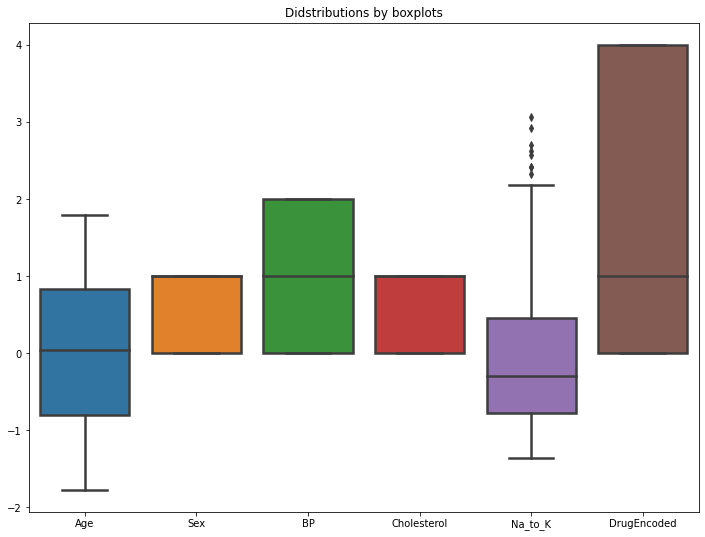

In [16]:
# Existen algunos outliers.
fig,ax = plt.subplots(figsize=(12,9))
g = sns.boxplot(data=df, linewidth=2.5, ax=ax)
plt.title('Didstributions by boxplots')
plt.show()

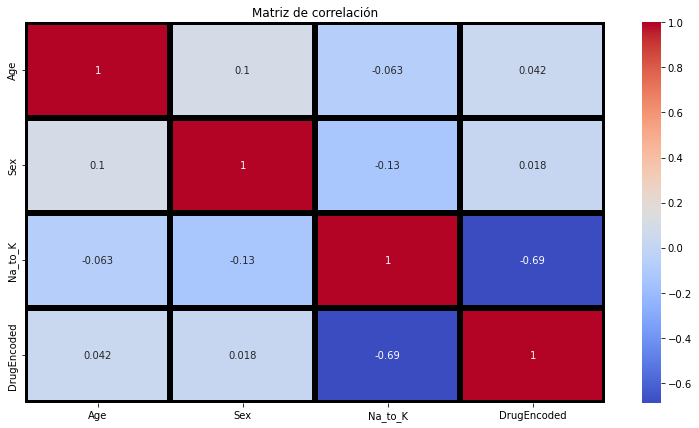

In [17]:
plt.figure(figsize=(13,7))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=5,linecolor="black")
plt.title("Matriz de correlación")
plt.show()

In [61]:
# Normalizamos los datos. 
df['Age'] = (df['Age']-df['Age'].mean())/df['Age'].std()
df['Na_to_K'] = (df['Na_to_K']-df['Na_to_K'].mean())/df['Na_to_K'].std()

In [71]:
#Separamos nuestras variables predictoras de nuestra variable a predecir que es Drug.
X = df.drop(columns=['Drug','DrugEncoded'])
y = df['DrugEncoded']

# Random Forest

In [72]:
#Partimos en train y test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [73]:
randomForestModel = RandomForestClassifier(max_depth=2, random_state=0) #Creando modelo de random forest.
randomForestModel.fit(X_train,y_train) # Entrenando modelo random forest.
rfpredict = randomForestModel.predict(X_test) # Prediciendo con el modelo ya entrenado.

In [74]:
#nuestra métrica para evaluar y comparar los modelos será la métrica f1, que es una clase de promedio entre precisión (precision) y la exhaustividad (recall).
f1 = f1_score(y_test, rfpredict, average="macro")
print(f'F1 score : {f1}') # obtenemos un f1 de 0.77

F1 score : 0.7714285714285715


In [75]:
confusion_matrix(y_test, rfpredict) #La matriz de confusión, notese que la droga número 4 no clasificó ninguno bien.

array([[7, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 6]])

Vamos a mejorar nuestro modelo de random forest tuneando los hyperparametros.

In [23]:
# Número de árboles en random forest, mínimo 1 máximo 20.
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Número de características a tener en cuenta en cada partición.
max_features = ['auto', 'sqrt']
# Máxima profundidad del árbol, mínimo 1 máximo 10.
max_depth = [int(x) for x in np.linspace(1, 10, num = 8)]
# Mínimo número de muestras requeridas para hacer la partición.
min_samples_split = [2, 5]

In [51]:
#Para tunear los hiperparámetros utilizaremos validación cruzada 3 veces, esto con el fin de estar seguros sobre los resultados.
best_f1 = 0
best_n_estimators = 0
best_max_features = 0
best_max_depth = 0
best_min_samples_split = 0

hyper = {
  'n_estimators':[],
  'max_features':[],
  'max_depth':[],
  'min_samples_split':[] ,
  'f1 score':[] 


}

for estimator in n_estimators:
  for feature in max_features:
    for depth in max_depth:
      for sample in min_samples_split:

        model = RandomForestClassifier(n_estimators = estimator, max_features = feature,max_depth=depth, 
                                       min_samples_split=sample)
        
        

        scores = cross_val_score(model,X,y,cv=5,scoring='f1_macro')
        f1 = np.mean(scores)
        print(f'n_estimators: {estimator} -- max_features: {feature} -- max_depth: {depth} -- min_samples_split: {sample}')
        print(scores, f'f1: {f1}')
        print("---------------------------------------------------------------------------------------------------------------------------------")

        hyper['n_estimators'].append(estimator)
        hyper['max_features'].append(feature)
        hyper['max_depth'].append(depth)
        hyper['min_samples_split'].append(sample)
        hyper['f1 score'].append(f1)

        if f1 > best_f1:
          best_f1 = f1
          best_n_estimators = estimator
          best_max_features = feature
          best_max_depth = depth
          best_min_samples_split = sample

        

n_estimators: 1 -- max_features: auto -- max_depth: 1 -- min_samples_split: 2
[0.3375     0.17754386 0.23226891 0.31959459 0.16851852] f1: 0.24708517606505223
---------------------------------------------------------------------------------------------------------------------------------
n_estimators: 1 -- max_features: auto -- max_depth: 1 -- min_samples_split: 5
[0.13760684 0.12413793 0.23226891 0.12413793 0.12413793] f1: 0.1484579076546622
---------------------------------------------------------------------------------------------------------------------------------
n_estimators: 1 -- max_features: auto -- max_depth: 2 -- min_samples_split: 2
[0.3375     0.52051282 0.33333333 0.51510742 0.33333333] f1: 0.4079573804573805
---------------------------------------------------------------------------------------------------------------------------------
n_estimators: 1 -- max_features: auto -- max_depth: 2 -- min_samples_split: 5
[0.3375     0.32792793 0.52984615 0.30501792 0.50933333] 

In [52]:
#Podemos hacer un dataframe con todos los hiperparámetros probados y sus respectivás métricas f1.

pd.DataFrame.from_dict(hyper)

,n_estimators,max_features,max_depth,min_samples_split,f1 score
0,1,auto,1,2,0.247085
1,1,auto,1,5,0.148458
2,1,auto,2,2,0.407957
3,1,auto,2,5,0.401925
4,1,auto,3,2,0.507979
...,...,...,...,...,...
315,20,sqrt,7,5,0.960616
316,20,sqrt,8,2,0.947783
317,20,sqrt,8,5,0.970347
318,20,sqrt,10,2,0.947783


In [26]:
#Ya que tenemos los mejores hiperparámetros que ofrecen la métrica f1 más alta, entrenaremos un mejor modelo.
best_model_random_forest = RandomForestClassifier(n_estimators = best_n_estimators, max_features = best_max_features
                                                  ,max_depth=best_max_depth,min_samples_split=best_min_samples_split)
best_model_random_forest.fit(X_train, y_train)
rfpredict = best_model_random_forest.predict(X_test)

In [27]:
f1 = f1_score(y_test, rfpredict, average="macro")
print(f'F1 score : {best_f1}')
#Como podemos ver pasamos de 0.77 a 0.97 en nuestra métrica f1.

F1 score : 0.9853777933777934


# Gaussian Naive Bayes

In [28]:
#Partición de datos en train y test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=24)

In [29]:
gnb_model = GaussianNB() # Creación del modelo de Gaussian Naive Bayes.
gnb_model.fit(X_train,y_train)# Entrenamiento del modelo.

GaussianNB()

In [30]:
gnbpredict = gnb_model.predict(X_test) # Predicción con el modelo de Gaussian Naive Bayes.

In [31]:
f1 = f1_score(y_test, gnbpredict, average="macro")
print(f'F1 score : {f1}') #Con este modelo inicial obtenemos una métrica f1 del 0.8

F1 score : 0.8033333333333333


In [32]:
confusion_matrix(y_test, gnbpredict) #Matriz de confusión, esta vez el algoritmo no clasifico de manera correcta todas las drogas de la clase 1.

array([[6, 2, 1, 1, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 4]])

Tunearemos los hiperparámetros para buscar un mejor desempeño del algoritmo.En este caso para GNB el único hyperparametro para tunear es var_smoothing.

In [33]:
 var_smoothing = np.logspace(0,-9, num=100)

In [ ]:
#Nuevamente utilizaremos validación cruzada para tunear los hiperparámetros.
best_f1 = 0
best_var_smoothing = 0


hyper = {
  'var_smoothing':[],
  'f1 score':[] 


}

for var in var_smoothing:


  model = GaussianNB(var_smoothing=var)
        
  scores = cross_val_score(model,X,y,cv=5,scoring='f1_macro')
  f1 = np.mean(scores)
  print(f'var_smoothing: {var} -- f1: {f1}')
  print(scores)
  print("---------------------------------------------------------------------------------------------------------------------------------")

  hyper['var_smoothing'].append(var)
  hyper['f1 score'].append(f1)

  if f1 > best_f1:

    best_f1 = f1
    best_var_smoothing = var



In [54]:
#Podemos hacer un dataframe con todos los hiperparámetros probados y sus respectivás métricas f1.

pd.DataFrame.from_dict(hyper)

,var_smoothing,f1 score
0,1.000000e+00,0.620669
1,8.111308e-01,0.694779
2,6.579332e-01,0.710063
3,5.336699e-01,0.702380
4,4.328761e-01,0.734564
...,...,...
95,2.310130e-09,0.815624
96,1.873817e-09,0.815624
97,1.519911e-09,0.815624
98,1.232847e-09,0.815624


In [35]:
#Ya que tenemos los mejores hiperparámetros que ofrecen la métrica f1 más alta, entrenaremos un mejor modelo.
best_model_gnb = GaussianNB(var_smoothing=best_var_smoothing)
best_model_gnb.fit(X_train, y_train)
gnbpredict = best_model_gnb.predict(X_test)

In [36]:
f1 = f1_score(y_test, gnbpredict, average="macro")
print(f'F1 score : {f1}')
#Como podemos ver pasamos de 0.8 a 0.95 en nuestra métrica f1.

F1 score : 0.9494736842105264


In [37]:
confusion_matrix(y_test, gnbpredict)# Matriz de confusión.

array([[9, 1, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 4]])